## Model 1: Showcase

- fit baseline model to period of April 2020 - end of November 2020, everything observed

In [1]:
from src.model import account_for_nans, _model, to_log_probs

In [2]:
import jax

jax.config.update("jax_enable_x64", True)

In [3]:
import pandas as pd
import jax.random as jrn
from jax import numpy as jnp, vmap
from isssm.laplace_approximation import laplace_approximation as LA
from isssm.modified_efficient_importance_sampling import (
    modified_efficient_importance_sampling as MEIS,
)
from isssm.estimation import mle_pgssm, initial_theta
from isssm.importance_sampling import (
    pgssm_importance_sampling,
    ess_pct,
    mc_integration,
    prediction_percentiles,
    normalize_weights,
)
from isssm.kalman import state_mode
import matplotlib.pyplot as plt
import matplotlib as mpl

mpl.rcParams["figure.figsize"] = (20, 6)

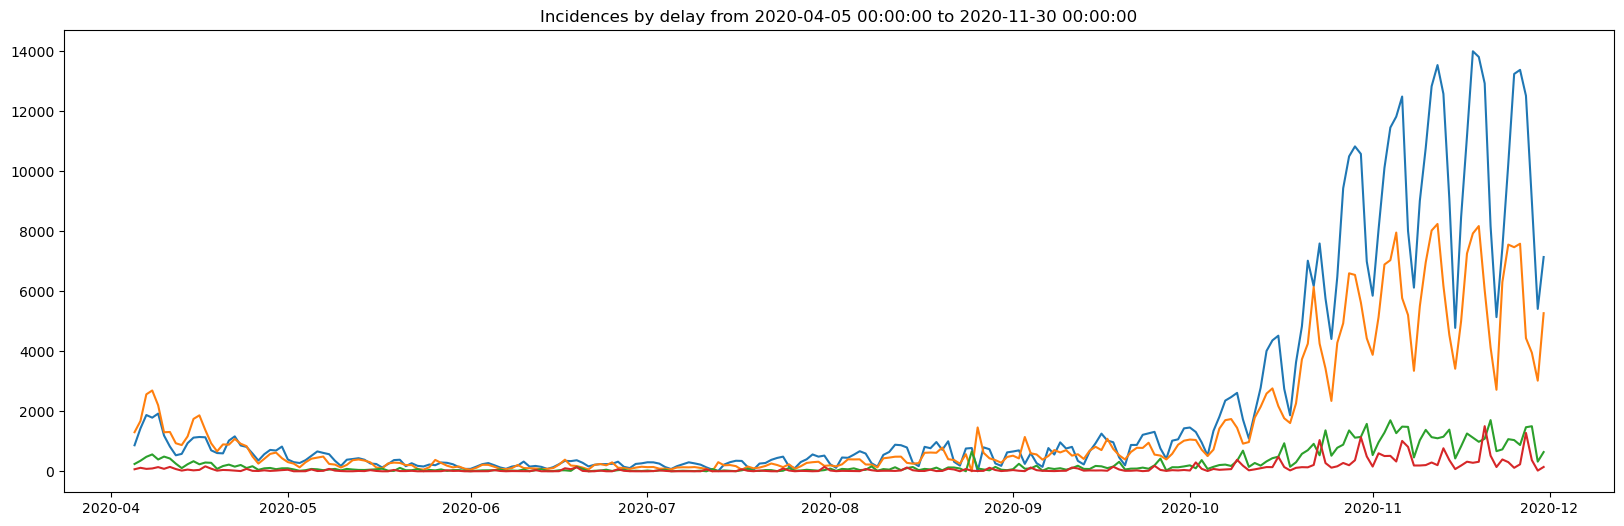

In [4]:
key = jrn.PRNGKey(34234234)

i_start = 0
np1 = 240
df = pd.read_csv("../../../data/processed/RKI_4day_rt.csv")
dates = pd.to_datetime(df.iloc[i_start : i_start + np1, 0])
y = jnp.asarray(df.iloc[i_start : i_start + np1, 1:].to_numpy())

plt.plot(dates, y)
plt.title(f"Incidences by delay from {dates[0]} to {dates[np1-1]}")
plt.show()

In [5]:
theta_manual = jnp.log(
    # s2_log_rho, s2_W, s2_q, s2_M
    jnp.array([0.001**2, 0.1**2, 0.5**2, 0.01**2])
)
aux = (np1, 4)
intial_result = initial_theta(y, _model, theta_manual, aux, 10)
theta_0 = intial_result.x
intial_result

  message: Optimization terminated successfully.
  success: True
   status: 0
      fun: 6.49885161921508
        x: [-8.511e+00 -7.691e+00  5.779e-01 -4.446e+00]
      nit: 43
      jac: [-9.022e-09 -3.544e-07 -6.164e-07  6.146e-07]
 hess_inv: [[ 1.862e+02  1.233e+01  1.569e-01 -2.226e+01]
            [ 1.233e+01  1.565e+02 -3.484e-02 -1.292e+01]
            [ 1.569e-01 -3.484e-02  3.612e+00 -1.287e-01]
            [-2.226e+01 -1.292e+01 -1.287e-01  2.062e+01]]
     nfev: 432
     njev: 48

In [6]:
key, subkey = jrn.split(key)
mle_result = mle_pgssm(y, _model, theta_0, aux, 10, 1000, subkey)
theta_hat = mle_result.x
mle_result

  message: Optimization terminated successfully.
  success: True
   status: 0
      fun: 6.497867327367745
        x: [-8.511e+00 -7.691e+00  5.795e-01 -4.446e+00]
      nit: 3
      jac: [-1.442e-06 -8.462e-07 -1.144e-08 -1.484e-06]
 hess_inv: [[ 1.000e+00  8.639e-05  2.250e-02  1.960e-04]
            [ 8.639e-05  1.000e+00  1.332e-02  1.161e-04]
            [ 2.250e-02  1.332e-02  4.188e+00  2.981e-02]
            [ 1.960e-04  1.161e-04  2.981e-02  1.000e+00]]
     nfev: 36
     njev: 4

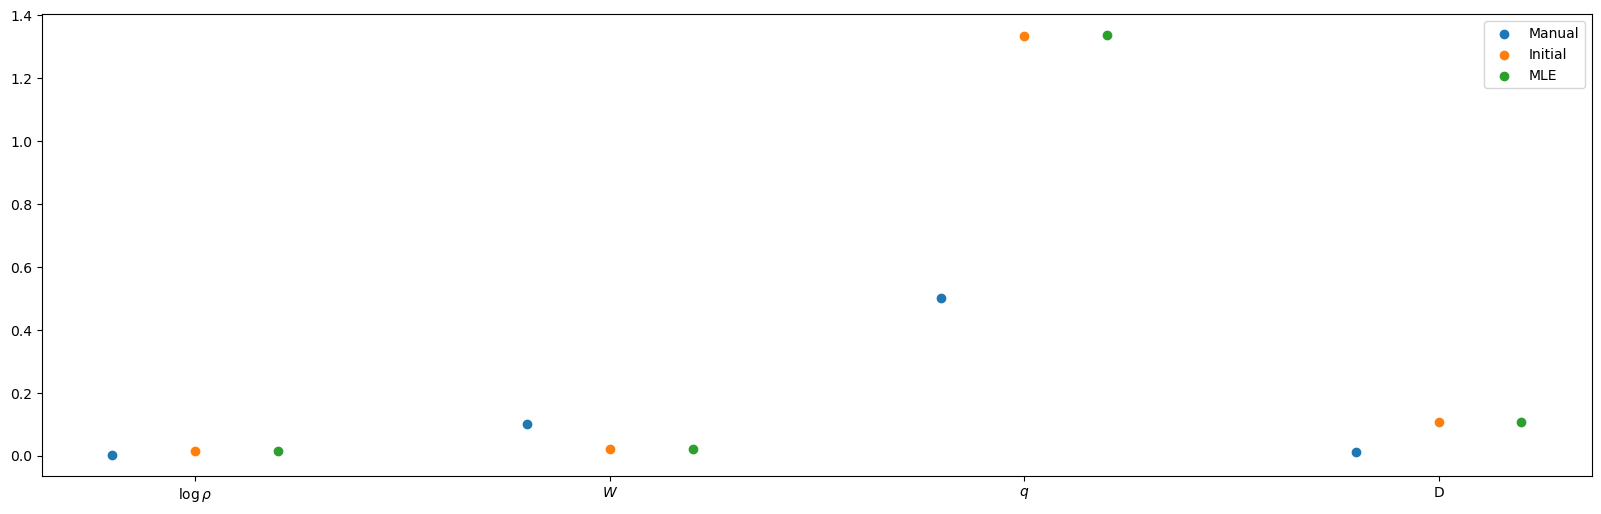

In [7]:
s_manual = jnp.exp(theta_manual / 2)
s_0 = jnp.exp(theta_0 / 2)
s_mle = jnp.exp(theta_hat / 2)

k = theta_manual.size
plt.scatter(jnp.arange(k) - 0.2, s_manual, label="Manual")
plt.scatter(jnp.arange(k), s_0, label="Initial")
plt.scatter(jnp.arange(k) + 0.2, s_mle, label="MLE")
plt.xticks(jnp.arange(k), ["$\\log \\rho$", "$W$", "$q$", "D"])
plt.legend()
plt.show()

In [8]:
fitted_model = _model(theta_hat, aux)
proposal_la, info_la = LA(y, fitted_model, 10)
key, subkey = jrn.split(key)
proposal_meis, info_meis = MEIS(
    y, fitted_model, proposal_la.z, proposal_la.Omega, 10, 1000, subkey
)
key, subkey = jrn.split(key)
samples, lw = pgssm_importance_sampling(
    y, fitted_model, proposal_meis.z, proposal_meis.Omega, 1000, subkey
)
ess_pct(lw)

Array(8.27997248, dtype=float64)

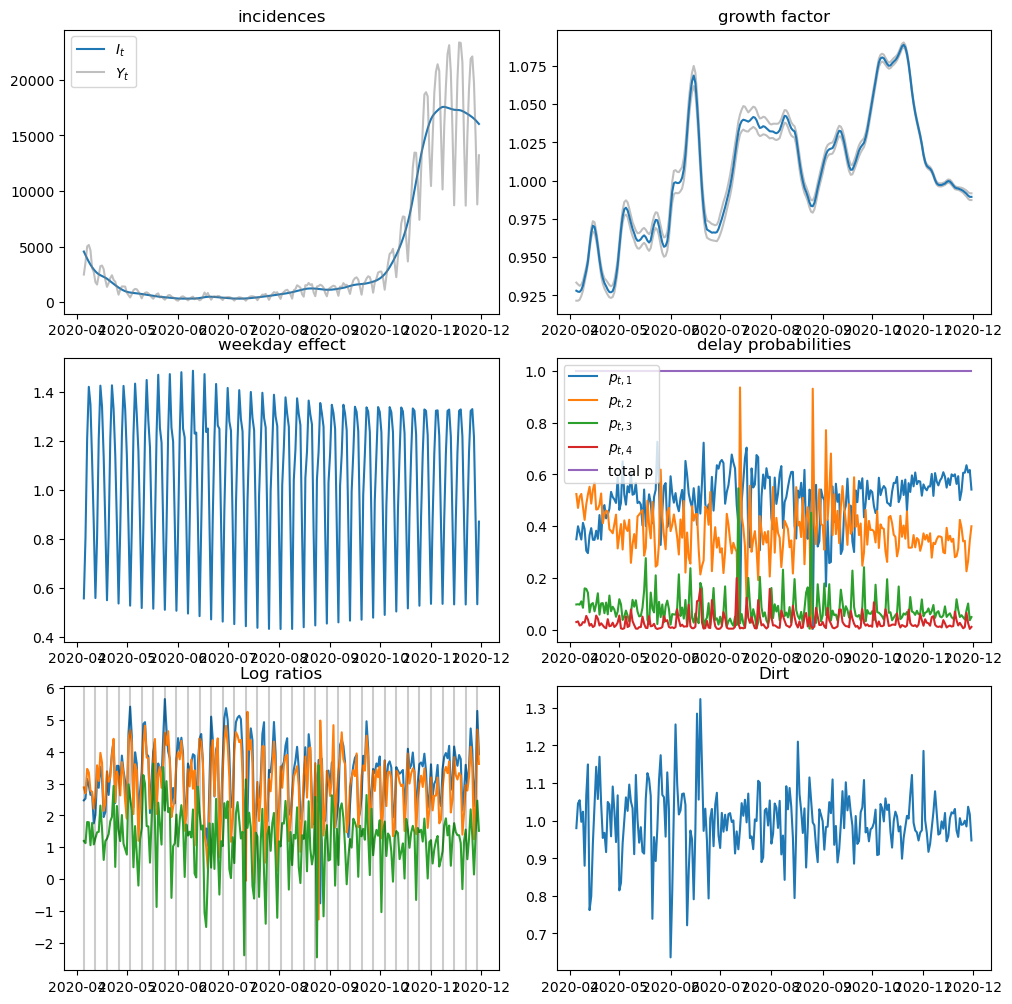

In [9]:
state_modes_meis = vmap(state_mode, (None, 0))(fitted_model, samples)
x_smooth = mc_integration(state_modes_meis, lw)
x_lower, x_mid, x_upper = prediction_percentiles(
    state_modes_meis, normalize_weights(lw), jnp.array([2.5, 50.0, 97.5]) / 100.0
)

# I_smooth = jnp.exp(x_smooth[:, 0])
I_smooth = mc_integration(jnp.exp(state_modes_meis[:, :, 0]), lw)
rho_smooth = jnp.exp(x_smooth[:, 1])
D_smooth = jnp.exp(x_smooth[:, 2])
W_smooth = jnp.exp(x_smooth[:, 3])
log_ratios = x_smooth[:, 9:12]
log_probs = to_log_probs(log_ratios)

fig, axs = plt.subplots(3, 2, figsize=(10, 10))

axs = axs.flatten()
fig.tight_layout()

axs[0].set_title("incidences")
axs[0].plot(dates, I_smooth, label="$I_t$")
# axs[0].plot(dates, jnp.exp(x_lower[:, 0]), color="black", linestyle="dashed")
axs[0].plot(dates, y.sum(axis=1), label="$Y_t$", color="grey", alpha=0.5)
axs[0].legend()

axs[1].set_title("growth factor")
axs[1].plot(dates, jnp.exp(x_lower[:, 1]), color="grey", alpha=0.5)
axs[1].plot(dates, jnp.exp(x_upper[:, 1]), color="grey", alpha=0.5)
axs[1].plot(dates, rho_smooth, label="$\\log \\rho_t$")

axs[2].set_title("weekday effect")
axs[2].plot(dates, W_smooth, label="$W_t$")

axs[3].set_title("delay probabilities")

axs[3].plot(dates, jnp.exp(log_probs[:, 0]), label="$p_{t, 1}$")
axs[3].plot(dates, jnp.exp(log_probs[:, 1]), label="$p_{t, 2}$")
axs[3].plot(dates, jnp.exp(log_probs[:, 2]), label="$p_{t, 3}$")
axs[3].plot(dates, jnp.exp(log_probs[:, 3]), label="$p_{t, 4}$")
axs[3].plot(dates, jnp.exp(log_probs).sum(axis=1), label="total p")
axs[3].legend()

axs[4].set_title("Log ratios")
axs[4].plot(dates, log_ratios[:, 0], label="$q_{t, 1}$")
axs[4].plot(dates, log_ratios[:, 1], label="$q_{t, 2}$")
axs[4].plot(dates, log_ratios[:, 2], label="$q_{t, 3}$")
for d in dates[::7]:
    axs[4].axvline(d, color="black", alpha=0.2)

axs[5].set_title("Dirt")
axs[5].plot(dates, D_smooth)
plt.show()

## Storing results

In [10]:
# theta
df_theta = pd.DataFrame.from_records(
    jnp.vstack([theta_manual, theta_0, theta_hat]),
    columns=["log rho", "W", "q", "M"],
    index=["manual", "initial", "MLE"],
)
df_theta.to_csv(
    "../../../data/results/4_showcase_model/thetas.csv", index_label="method"
)
df_theta

,log rho,W,q,M
manual,-13.815510557964274,-4.605170185988091,-1.3862943611198906,-9.210340371976182
initial,-8.510854898970004,-7.691462843622975,0.5779217399992015,-4.445763476758061
MLE,-8.510845242723423,-7.691457122484512,0.5795064679171656,-4.445750349834347


In [68]:
from jaxtyping import Float, Array

# predictions

# date / name / mean / sd / percentiles

# same as in FCH
percentiles_of_interest = jnp.array(
    [0.01, 0.025, *(0.05 * jnp.arange(1, 20)), 0.975, 0.99]
)


def summary_stats(samples: Float[Array, "N m"], log_weights: Float[Array, "N"]):
    mean = mc_integration(samples, log_weights)
    var = mc_integration(samples**2, log_weights) - mean**2
    sd = jnp.sqrt(var)

    percentiles = prediction_percentiles(
        samples[:, :, None], normalize_weights(log_weights), percentiles_of_interest
    ).squeeze(-1)

    return jnp.vstack((mean, sd, percentiles)).T

def summary_stats_Y(samples: Float[Array, "N m"], log_weights: Float[Array, "N"]):
    mean = (fitted_model.dist(samples, fitted_model.xi).mean() * normalize_weights(log_weights)[...,None]).sum()


def df_for_date(date_index: int):
    N, np1, m = state_modes_meis.shape
    df_states = pd.DataFrame.from_records(
        summary_stats(state_modes_meis[:, date_index], lw),
        columns=["mean", "sd", *[f"{prob:.3f}" for prob in percentiles_of_interest]],
    )
    df_states.insert(0, "name", [f"X_{i}" for i in range(m)])
    df_states.insert(0, "date", dates[date_index])

    df_I = pd.DataFrame.from_records(
        summary_stats(jnp.exp(state_modes_meis[:, date_index, 0]), lw),
        columns=["mean", "sd", *[f"{prob:.3f}" for prob in percentiles_of_interest]],
    )
    df_I.insert(0, "name", "I")
    df_I.insert(0, "date", dates[date_index])

    df_Y = pd.DataFrame.from_records(

        summary_stats(jnp.exp(log_probs[date_index]), lw),
        columns=["mean", "sd", *[f"{prob:.3f}" for prob in percentiles_of_interest]],
    )

    return df_states


df = pd.DataFrame()
for i in range(np1):
    df = pd.concat([df, df_for_date(i)])

df

,date,name,mean,sd,0.010,0.025,0.050,0.100,0.150,0.200,...,0.600,0.650,0.700,0.750,0.800,0.850,0.900,0.950,0.975,0.990
0,2020-04-05,X_0,8.422226473738768,0.012440780132629052,8.395190344140428,8.399064110279062,8.40152479529752,8.405931101792742,8.408792444159268,8.411452997480556,...,8.425945224577093,8.426839613319821,8.428727677837648,8.429777696845377,8.431475861847252,8.434752402553016,8.438832518527771,8.442933187176617,8.446456422409257,8.451935871153488
1,2020-04-05,X_1,-0.07473942509948046,0.00333744785986492,-0.0831915201294204,-0.08155488255210577,-0.08032879339944643,-0.07909002584962006,-0.07809538235515527,-0.07736755654921786,...,-0.07415918882893455,-0.07370958394504594,-0.0730498961473757,-0.07254839583233993,-0.07179455317145689,-0.071105259021849,-0.07030484283685992,-0.06922417711135,-0.06869225145965772,-0.06683614164519433
2,2020-04-05,X_2,-0.02170868212123675,0.021845750509966663,-0.07430946173328325,-0.06465565005249464,-0.05860727261370925,-0.048459341081256116,-0.043020612605926836,-0.039617672756900334,...,-0.016911297916599278,-0.013001570262431738,-0.009235746605136666,-0.005994267183605609,-0.0027043148558315885,0.0012544547582859743,0.005853416530920459,0.012871290794084002,0.01914817828498703,0.0271283522975496
3,2020-04-05,X_3,-0.5845191006815046,0.009854932108824498,-0.6062906578080909,-0.6048077565697939,-0.6019521871708566,-0.5978116892889397,-0.5957344309453625,-0.5931139932317248,...,-0.5813711062375899,-0.5797310543642038,-0.5783340786832158,-0.5778335129454634,-0.5767212537175027,-0.5745759517922732,-0.5722944869903945,-0.5695948075060903,-0.5665636477941003,-0.5620874348724141
4,2020-04-05,X_4,-0.15113010234149968,0.009516727648637148,-0.17152716044094118,-0.16874256823685163,-0.16575800446413627,-0.1634060850003054,-0.16103654970096776,-0.15889143578980391,...,-0.14875887766808404,-0.1477363825319936,-0.14645973191014877,-0.1448830926288306,-0.14331701561514001,-0.1411905423447516,-0.13872033404583733,-0.13427911235299758,-0.1306136570335594,-0.12876904654393764
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7,2020-11-30,X_7,0.2838671933797095,0.0027621412332109753,0.27825497926050136,0.2792055304949427,0.2797025623327026,0.2804385088424313,0.28100653133942644,0.2812198497410693,...,0.28448810291806653,0.28481789882106606,0.28533121100825676,0.28585947950095825,0.2863925343769046,0.28693230936780706,0.2875970486397827,0.2886138389431557,0.28931762687383356,0.2899838397922866
8,2020-11-30,X_8,0.2788690715886717,0.002866649736075359,0.2721327683857344,0.27335350831906385,0.27400064776550564,0.2751076741041031,0.2760019782648716,0.27663731225595123,...,0.27951323777564857,0.2798959197349727,0.280265216526302,0.2808332586663633,0.28132641128740143,0.28194310327296174,0.28301741495444876,0.28331974381257014,0.2839698774618645,0.285055250529848
9,2020-11-30,X_9,3.9292040517736053,0.09311292110900013,3.721963326722805,3.760130185327425,3.7768591796905824,3.8132708312988397,3.8366116227291847,3.8481104955848013,...,3.9496276528122647,3.9623554067662052,3.9759852285302872,3.990537559185466,4.004700831043894,4.027229331976826,4.048216352664514,4.098750919250598,4.1297089983188995,4.132853869751124
10,2020-11-30,X_10,3.625060154797921,0.09614613703581756,3.4141370940259685,3.4483207531209707,3.46986167278692,3.5043641866520066,3.5269652698157516,3.5457072995479724,...,3.649119174833704,3.6597517978138625,3.6713290531683644,3.682284563320846,3.701397533485558,3.7247401662951534,3.7508730982802994,3.7992275428700895,3.8345852709660755,3.839677432559555
